In [1]:
import torch
import numpy as np
from dataset import Animal10
import torchvision.transforms as tf
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
from itertools import cycle

In [2]:
transforms = tf.Compose([
    tf.ToTensor(),
    tf.Resize((224,224)),
    # tf.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    tf.RandomHorizontalFlip(),
    # v2.CutMix(alpha=1,num_classes=10),
])

In [3]:
dataset = Animal10(False,transform=transforms)
data_loader = DataLoader(dataset, 4, True)
cut_mix = v2.CutMix(alpha=1., num_classes=10)

c:\Users\mg352\anaconda3\envs\ML_cuda2\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([0.0000, 0.0000, 0.0000, 0.6319, 0.0000, 0.0000, 0.0000, 0.3681, 0.0000,
        0.0000])


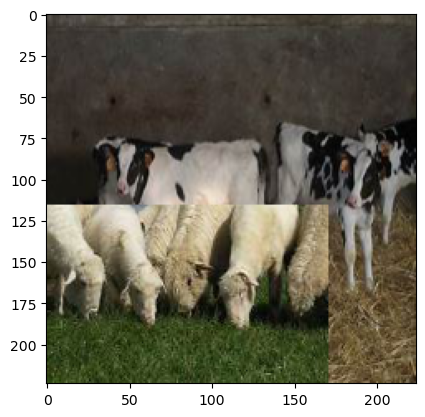

In [4]:
img,label = next(iter(data_loader))
new_img, label = cut_mix(img,label)
img_p = img.permute(0,2,3,1)
new_img_p = new_img.permute(0,2,3,1)
plt.imshow(new_img_p[0])
print(label[0])


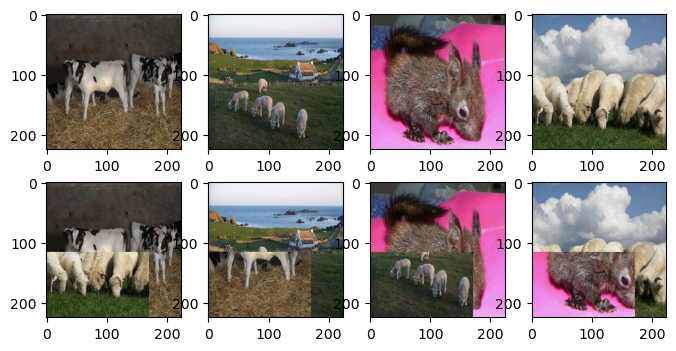

tensor([0.0000, 0.0000, 0.0000, 0.6319, 0.0000, 0.0000, 0.0000, 0.3681, 0.0000,
        0.0000])


In [5]:
plt.figure(figsize=(8,4))
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(img_p[i])
for i in range(4):
    plt.subplot(2,4,i+5)
    plt.imshow(new_img_p[i])
# for i in range(4):
#     ax[i].imshow(img_p[i])
# plt.imshow(img_p[0])
# plt.imshow(new_img_p[0])
plt.show()
print(label[0])

In [17]:
%reload_ext autoreload
%autoreload 2

from augmentation import *


In [18]:
sample_loader = DataLoader(dataset,batch_size=4,shuffle=True)

# gcm = grid_cut_mix_v4(10,[224,224],grid=56,grid_type='grid')
gcm = grid_cut_mix_v5(10,[224,224],grid=56,grid_type='grid')
# gcm.slice_map.float()

torch.Size([3, 224, 224])
tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.0000])


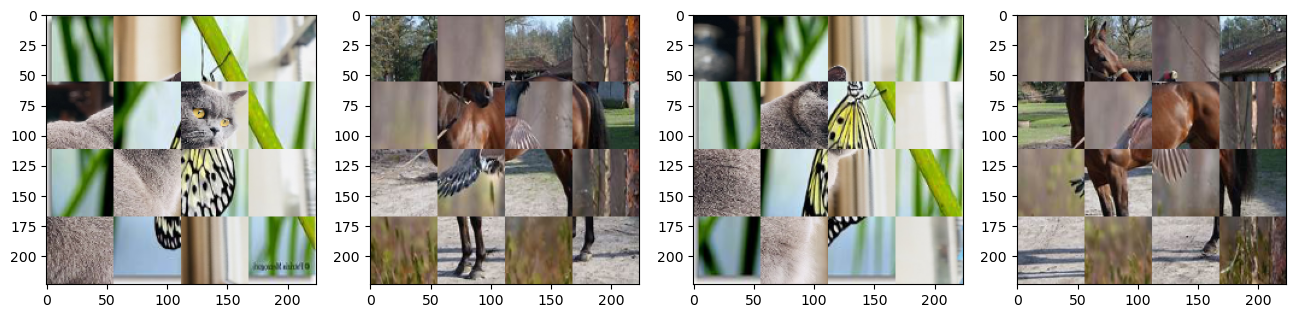

In [19]:
img,label = next(iter(data_loader))
new_img,label = gcm(img,label)
img_p = img.permute(0,2,3,1)
new_img_p = new_img.permute(0,2,3,1)
idx=1
plt.figure(figsize=(16,16))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(new_img_p[i])
# plt.imshow(new_img_p[idx])
print(label[idx])